# Real World Application

## Description of the Problem

El ebola fue por primera vez identificado en 1976 despues de un brote en lo que hoy es la Republica Democratica del Congo, desde entonces, esta clase de virus emergen periodicamente y el virus de ebola es uno de los mas mortales, sin tratamiento el 90% de los casos son fatales [1]. 

Por la mortal que puede llegar a ser, es un problema de gran impacto sanitario y se pretende hacer lo siguiente en el notebook para ayudar a tener mejores herramientas frente a estos casos

-   **Predicciones para datos faltantes:** Tener datos incompletos es un problema comun, para ello con el metodo de Polynomial Least Squares, trataremos de hacer predicciones sobre estos datos, para ello vamos a tomar datos conocidos para dividirlos entre entrenamiento y test, hacer polinomios interpolantes para los datos de entrenamiento y vamos a presentar el promedio de la suma de los errores al cuadrado(mse) 

-   **Estimacion de los parametros del modelo:** Los brotes de ebola se suelen modelar con una regresion logistica, con un metodo dentro de la categoria de Non-Linear Least Squares, se buscaran los mejores coeficientes para el modelo de regresion logistica

## Data

En 1995 se produjo un brote de la especie Zaire ebolavirus en la ciudad de Kiwkwit y sus alrededores

Se tiene un dataset que contiene una serie de tiempo con los conteos de nuevos individuos que presentan signos clinicos y el numero de nueva eliminaciones de cada dia del brote de Ebola de 1995 en la Republica Democratica del Congo [2].

El dataset es un dataframe con 192 filas y 3 variables:
-   **time** dias desde el 1 de Enero de 1995
-   **clin_signs** numero de nuevos casos clinicos por cada dia
-   **removals** numero de nuevas eliminaciones por cada dia

Aunque se va a modificar el dataset para que `clin_signs` contenga el acumulado de los casos que presentan signos clinicos

## Implementation

### Setup and Configuration

Las siguientes celdas estan dedicadas a preparar el entorno para las implementaciones, especificamente

- **Installar dependencias adicionales:** Instala el paquete rdata, ademas se supone que ya estan instaladas las dependecias del archivo requirements.txt
- **Importar librerias:** jax, rdata, matplotlib, pandas
- **Cargar el dataset:** ebola.rda en la variable `dataframe`
- **Configuracion:** se modifica una configuracion de jax para permitir flotantes de 64 bits

In [1]:
!pip install -q rdata

In [2]:
import rdata
from jax.numpy import sqrt, exp, power, linalg, linspace
import pandas as pd
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
import jax
from random import sample

np = jnp
jax.config.update("jax_enable_x64", True) # To supress the warning when doing the non-linear least squares approximation

In [3]:
parsed = rdata.parser.parse_file('ebola.rda')

# Convierte los objetos cargados a Python
dataframe = rdata.conversion.convert(parsed)
dataframe = next(iter(dataframe.values()))
dataframe['clin_signs'] = dataframe['clin_signs'].cumsum()

all_data = dataframe
main_data = dataframe.iloc[50:-20]

In [4]:
percentage = 0.7
k = int(len(all_data) * percentage)
train_ind = sample(range(1, 1 + len(all_data)), k)
train_ind.sort()

test_ind = [i for i in range(1, 1 + len(all_data)) if not i in train_ind]

In [5]:
train_data = all_data.loc[train_ind]
test_data = all_data.loc[test_ind]
train_data.head()

,time,clin_signs,removals
1,0,1,0
2,1,1,0
3,2,1,0
4,3,1,0
5,4,1,0


### Polynomial Least Squares

> Se va a llamar punto a los pares de (dia, casos reportados hasta tal dia) que contiene el dataset, note que no se utiliza la informacion de la variable `removals` del dataset

Vamos a tratar de modelar el comportamiento del ebola con polinomios de grado n que minimicen la suma de los errores al cuadrado de los puntos del dataset

Con esa intencion se va a ejecutar la funcion `polynomial_least_squares(x, y, x_pred, n)` que evalua $P_n(x_{pred})$, donde 
$$P_n(x) = a_n x^n + \dots + a_1 x + a_0$$
y los coeficientes $a_1, \dots, a_n$ son elejidos de tal manera que minizan la suma de los errores al cuadrado de los puntos del dataset (Burden, Faires, & Burden, 2015, p. 501) [3]

In [6]:
def polynomial_least_squares(x, y, x_pred, n, print_polynomial = True):
    """
    Evaluates P_n(x_pred) where P_n is the algebraic polynomial
    P_n(x) = a_n x^n + a_(n-1) x^(n-1) + ... + a_1 x + a_0 of degree n < m - 1
    choosing a_0, ..., a_n to minimize the sum of the squares error of the given points

    Args:
        x (np.array)
        y (np.array)
        x_pred (float)
        n (int)

    Returns:
        (int) P_n(x_pred)
    """
    m = len(x) # number of points
    assert n < m - 1
    assert len(x) == len(y), "There are not equal number of x_cords and y_cords"

    # Ap = b will be normal equations written in matrix form
    # where x = (a_0, a_1, ..., a_n)
    A = [[0 for _ in range(n + 1)] for _ in range(n + 1)]
    b = [[0 for _ in range(1)] for _ in range(n + 1)]

    for i in range(n + 1):
        for j in range(n + 1):
            A[i][j] = sum(x[k]**(i + j) for k in range(m + 1))

    for i in range(n + 1):
        b[i] = sum(y[j]*x[j]**i for j in range(m + 1))

    # the solution of x to the system Ax=b will give the constants
    # p = (a_0, a_1, ..., a_n)
    # such that the polynomial P_n(x) = a_n x^n + ... + a_0
    # minimizes the sum of squares error of the given points

    p = np.linalg.solve(np.array(A), np.array(b))
    if print_polynomial:
        print(f"P_{n}(x) = " + " + ".join(f"({round(p[i], 2)})x^{i}" for i in range(n + 1)))
    
    # evaluate, p constains the coefficients of the polynomial of grade n
    return sum(p[i]*x_pred**i for i in range(n + 1))

### Non-linear Least Squares

In [7]:
def regresion(xi, ai, b0i, b1i):
  """
    Regresion Logistica

    ai -> tope de la grafica
    b0i -> intercepto con el eje x
    b1i -> pendiente con el eje x
  """
  return ai / (1 + exp(-(b0i + b1i*xi)))

def calcular_jacobiano(arr_X, params):
  """
  Calcula el Jacobiano de la función 'regresion' para una lista de valores de xi.
  """
  # Define una función que toma los parámetros (ai, b0i, b1i, ci)
  # y devuelve el valor de la función 'regresion' para un xi dado
  def regresion_para_xi(params):
      return arr_X - regresion(arr_X, *params)

  # Calcula el Jacobiano de 'regresion_para_xi' usando jacfwd
  jacobiano = jacfwd(regresion_para_xi)(params)

  return jacobiano

def vector_residuo(arr_X, arr_Y, B):
  return arr_Y - regresion(arr_X, *B)

In [8]:
def suma_de_errores_cuadrados(arr_X, arr_Y, B):
  vector = vector_residuo(arr_X, arr_Y, B)
  return sum([
      np.power(elem, 2) for elem in vector
  ])

def sanitizar_inversa(matrix, det_tol):
  if linalg.det(matrix) < det_tol:
    return linalg.pinv(matrix)

  return linalg.inv(matrix)

def Gauss_Newton(max_iter, tol, inicio, arr_X, arr_Y, det_tol):
  B = inicio
  valores_iteracion = []

  for i in range(max_iter):
    J = calcular_jacobiano(arr_X, B)
    JtJ_inv = sanitizar_inversa(np.dot(J.T, J), det_tol)
    JtJ_invJt = np.dot(JtJ_inv, J.T)

    B -= np.dot(JtJ_invJt, vector_residuo(arr_X, arr_Y, B))

    temp = suma_de_errores_cuadrados(arr_Y, arr_X, B)

    if i>1:
      if jnp.any(jnp.isnan(temp)): break
      if abs(valores_iteracion[-1] - valores_iteracion[-2]) < tol: break

    valores_iteracion.append(temp)
    print("Iteracion:", i, "\tError Cuadrado:", temp)

  return B, valores_iteracion

## Visualization

### Polynomial Least Squares

Voy a generar una funcion que me va a ser util para graficar el polinomio de grado n que me de el metodo de polynomial least squares, junto con la grafica que generan los datos originales

In [9]:
def plot_polynomial_least_squares(n):
    # Retrieve from dataset original data
    train_X = jnp.array(train_data['time'].values.astype(np.float64))
    train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

    test_X = jnp.array(test_data['time'].values.astype(np.float64))
    test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

    # Predict new data
    x_pred = linspace(min(all_data["time"]), max(all_data["time"])) 
    y_pred =  polynomial_least_squares(train_X, train_Y, x_pred, n)

    r = test_Y - polynomial_least_squares(train_X, train_Y, test_X, n, False)
    squared_error = sum(ri*ri for ri in r)
    mse = squared_error / len(test_Y)
    print(f"Then the mean squared error is {round(mse, 2)}")

    # Plot
    plt.scatter(train_X, train_Y, s=1, color="black", label = "train_data")
    plt.scatter(test_X, test_Y, s=2, color="red", label = "test_data")

    plt.plot(x_pred, y_pred, label = f"Grade {n} Polynomial aproximation")

    plt.title(f"Polynomial least squares")
    plt.xlabel('Tiempo')
    plt.ylabel('Nuevos Casos')
    plt.legend()
    plt.show()

Vamos a ver el comportamiento que obtiene el polinomio de grado 1 (una linea) que minimiza la suma de minimos cuadrados

P_1(x) = (-85.02)x^0 + (2.0100000000000002)x^1
Then the mean squared error is 2198.06


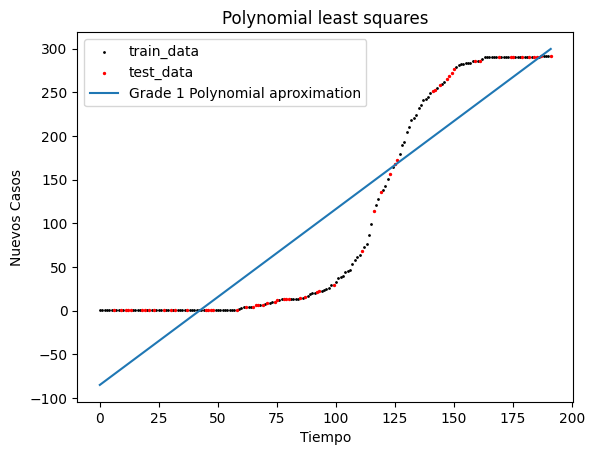

In [10]:
plot_polynomial_least_squares(1)

Voy a graficar para n = 1, 2, 3, 4, 5, los polinomios que genera el metodo de polynomial least squares en la misma figura, para visualizar y poder comparar rapidamente entre diferentes valores de n, con graficas parecidas a la anterior

P_1(x) = (-85.02)x^0 + (2.0100000000000002)x^1
Then the mean squared error is 2198.06
P_2(x) = (-6.41)x^0 + (-0.48)x^1 + (0.01)x^2
Then the mean squared error is 1200.44
P_3(x) = (44.96)x^0 + (-3.84)x^1 + (0.06)x^2 + (-0.0)x^3
Then the mean squared error is 555.97
P_4(x) = (-12.58)x^0 + (2.86)x^1 + (-0.11)x^2 + (0.0)x^3 + (-0.0)x^4
Then the mean squared error is 160.34
P_5(x) = (-16.1)x^0 + (3.52)x^1 + (-0.13)x^2 + (0.0)x^3 + (-0.0)x^4 + (0.0)x^5
Then the mean squared error is 164.07
P_6(x) = (16.25)x^0 + (-5.3)x^1 + (0.35000000000000003)x^2 + (-0.01)x^3 + (0.0)x^4 + (-0.0)x^5 + (0.0)x^6
Then the mean squared error is 72.29


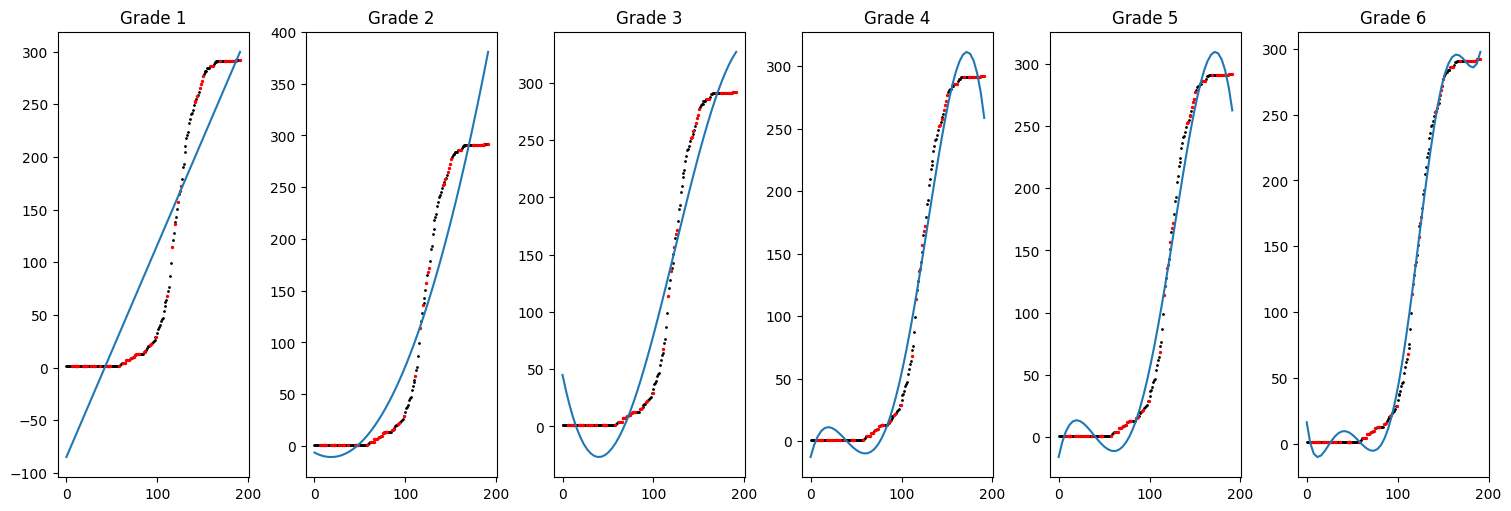

In [11]:
# Retrieve original data
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

m = 6
fig, axis = plt.subplots(1, m, figsize=(15, 5), constrained_layout=True) # This allows to do multiples plots in the same figure

for n in range(1, m + 1):
    # Do predictions
    x_pred = linspace(min(all_data["time"]), max(all_data["time"])) 
    y_pred =  polynomial_least_squares(train_X, train_Y, x_pred, n)

    r = test_Y - polynomial_least_squares(train_X, train_Y, test_X, n, False)
    squared_error = sum(ri*ri for ri in r)
    mse = squared_error / len(test_Y)
    print(f"Then the mean squared error is {round(mse, 2)}")

    # Plot prediction n at the column n-1
    axis[n - 1].scatter(train_X, train_Y, s=1, color="black", label = "train_data")
    axis[n - 1].scatter(test_X, test_Y, s=2, color="red", label = "test_data")
    axis[n - 1].plot(x_pred, y_pred, label = f"Grade {n} Polynomial aproximation")
    axis[n - 1].set_title(f"Grade {n}")

plt.show()

### Non-Linear Least Squares

Iteracion: 0 	Error Cuadrado: 1564803.5943042303
Iteracion: 1 	Error Cuadrado: 1533524.9262642548
Iteracion: 2 	Error Cuadrado: 1620785.1479802092
Iteracion: 3 	Error Cuadrado: 1614415.6217951458
Iteracion: 4 	Error Cuadrado: 1612896.0774152896
Iteracion: 5 	Error Cuadrado: 1612674.0525967753
Iteracion: 6 	Error Cuadrado: 1612651.4560540488
Iteracion: 7 	Error Cuadrado: 1612649.2508496346
Iteracion: 8 	Error Cuadrado: 1612649.0368436694
Iteracion: 9 	Error Cuadrado: 1612649.0160848454
Iteracion: 10 	Error Cuadrado: 1612649.0140713286
Iteracion: 11 	Error Cuadrado: 1612649.0138760265
Iteracion: 12 	Error Cuadrado: 1612649.0138570834
Iteracion: 13 	Error Cuadrado: 1612649.0138552457
Iteracion: 14 	Error Cuadrado: 1612649.0138550673
Iteracion: 15 	Error Cuadrado: 1612649.0138550496
Iteracion: 16 	Error Cuadrado: 1612649.0138550482
Resuelto en 17 iteraciones
Respuesta: [ 2.94959920e+02 -1.14373165e+01  9.38125679e-02]


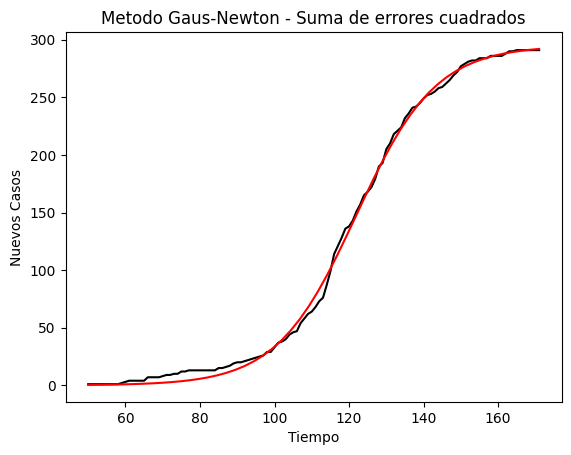

In [12]:
arr_X = jnp.array(main_data['time'].values.astype(np.float64))
arr_Y = jnp.array(main_data['clin_signs'].values.astype(np.float64))

iteraciones = 50
inicio = jnp.array([300, 1, 0]).astype(np.float64)
det_tol = 1e-12

B, error_gauss = Gauss_Newton(iteraciones, 1e-8, inicio, arr_X, arr_Y, det_tol)

new_X = linspace(arr_X[0], arr_X[-1])
new_Y_gauss = regresion(new_X, *B)

plt.plot(arr_X, arr_Y, color='black')
plt.plot(new_X, new_Y_gauss, color='red')
plt.title(f"Metodo Gaus-Newton - Suma de errores cuadrados")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')

print("Resuelto en", len(error_gauss), "iteraciones")
print("Respuesta:", B)
plt.show()

## Analysis of Results

El

## Bibliografia

1. Centers for Disease Control and Prevention (CDC). [Ebola Outbreaks](https://www.cdc.gov/ebola/outbreaks/index.html). Accessed January 12, 2025.
2. Dellicour, S., & Gilbert, M. (n.d.). *SimBIID: Simulation of Births, Immigration, and Deaths in Infectious Disease Epidemiology*. [R Package Documentation](https://cran.r-project.org/web/packages/SimBIID/SimBIID.pdf). Accessed January 12, 2025.
3. Burden, R. L., Faires, J. D., & Burden, A. M. (2015). *Numerical Analysis* (10th ed.). Cengage Learning.